<a href="https://colab.research.google.com/github/Norcrossover/NLP-HW2/blob/main/KobeNorcross_NLP_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import nltk
import json
import pandas as pd
import pdb
import collections
import nltk.metrics
import gensim.downloader
import string
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression
from nltk import precision
from nltk import recall
from nltk import f_measure
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# pretrained vectors
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

# data consts
REVIEW_TITLE_CONST = 'review_title'
STARS_CONST = 'stars'

# num_objs to train from data file
training_one_num_objs = 80000
training_two_num_objs = 40000

# file paths
content_drive_mount_path = '/content/drive'
training_data_file_path = content_drive_mount_path + '/My Drive/' + 'sentiment_train.json'
testing_data_file_path = content_drive_mount_path  + '/My Drive/' + 'sentiment_test.json'

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [41]:
def word2vec_embeddings(words):
    return np.array([word2vec_vectors[word] for word in words])

def glove_embeddings(words):
    return np.array([glove_vectors[word] for word in words])

def plot_embeddings(embeddings, words, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])
    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings[i, 0], embeddings[i, 1]))
    plt.show()

# visualize pretrained embeddings
def analyze_pretrained_vectors():
    emotion_words = ['happy', 'sad', 'angry', 'joy', 'surprised', 'disgusted', 'fearful', 'love', 'hate']
    gendered_words = ['man', 'woman', 'king', 'queen', 'doctor', 'nurse', 'engineer', 'teacher']

    # transform embeddings
    tsne = TSNE(n_components=2, random_state=0, perplexity=7)
    word2vec_emotion = tsne.fit_transform(word2vec_embeddings(emotion_words))
    word2vec_gendered = tsne.fit_transform(word2vec_embeddings(gendered_words))
    glove_emotion = tsne.fit_transform(glove_embeddings(emotion_words))
    glove_gendered = tsne.fit_transform(glove_embeddings(gendered_words))

    # plot data
    plot_embeddings(word2vec_emotion, emotion_words, 'word2vec_emotion')
    plot_embeddings(glove_emotion, emotion_words, 'glove_emotion')
    print()
    print()
    plot_embeddings(word2vec_gendered, gendered_words, 'word2vec_gendered')
    plot_embeddings(glove_gendered, gendered_words, 'glove_gendered')

In [11]:
# Opens the file path and reads in the json file line by line into the data object
def convert_json_to_object(file_path, num_objs):
    try:
        data = []
        with open(file_path) as file:
            for i, line in enumerate(file):
                if i >= num_objs:
                    break
                data.append(json.loads(line))
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"File {file_path} not found.")
    except Exception as e:
        print(f"Error: {e}")

In [13]:

def remove_punctuation(words):
    return [''.join(c for c in w if c not in string.punctuation and not c.isdigit()) for w in words]

def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

def lemmatize(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def remove_empty_tokens(words):
    return [word for word in words if word]

def preprocess_data(unprocessed_data):
    try:
        preprocessed_data = []
        for index, row in unprocessed_data.iterrows():
            words = nltk.word_tokenize(row[REVIEW_TITLE_CONST].lower())
            words = remove_punctuation(words)
            words = remove_empty_tokens(words)
            words = remove_stopwords(words)
            words = lemmatize(words)
            features = {word: True for word in words}
            updated_obj = (features, str(row[STARS_CONST]))
            preprocessed_data.append(updated_obj)
        return preprocessed_data
    except Exception as e:
        print(f"Error: {e}")

In [35]:

def model_analysis(classifier, testing_data):
    refsets = collections.defaultdict(set)
    testsets = collections.defaultdict(set)

    for i, (feats, label) in enumerate(testing_data):
        refsets[label].add(i)
        observed = classifier.classify(feats)
        testsets[observed].add(i)

    for label in set(refsets.keys()):
        if not (refsets[label] and testsets[label]):
            print(f"No instances of {label} predicted")
            return None
        else:
            classifier_metrics = {
                'precision': precision(refsets[label], testsets[label]),
                'recall': recall(refsets[label], testsets[label]),
                'f1': f_measure(refsets[label], testsets[label])
            }
            print(f'Precision for {label}:', classifier_metrics['precision'])
            print(f'Recall for {label}:', classifier_metrics['recall'])
            print(f'F1-Score for {label}:', classifier_metrics['f1'])
            print()
            return classifier_metrics

In [34]:
def compare_values(val):
    return 'an increase' if val > 0 else 'a decrease'

def model_evaluation(nbm, lrm, num_objs):
    print()
    print('--------------------------------------------------')
    print('This test was trained on ', num_objs, ' reviews.')

    # precision
    precision_val = (lrm['precision']-nbm['precision'])
    print('The Naive Bayes classifier\'s precision is ', nbm['precision'])
    print('while the Logistic Regression classifier\'s precision is ', lrm['precision'])
    print('There is ', compare_values(precision_val), ' of ', abs(precision_val), ' when in precision using logistic regression!')

    # recall
    recall_val =  (lrm['recall']-nbm['recall'])
    print('The Naive Bayes classifier\'s recall is ', nbm['recall'])
    print('while the Logistic Regression classifier\'s recall is ', lrm['recall'])
    print('There is ', compare_values(recall_val), ' of ', abs(recall_val), ' in recall when using logistic regression!')

    # f1 measure
    f1_val =  (lrm['f1']-nbm['f1'])
    print('The Naive Bayes classifier\'s f1 measure is ', nbm['f1'])
    print('while the Logistic Regression classifier\'s f1 measure is ', lrm['f1'])
    print('There is ', compare_values(f1_val), ' of ', abs(f1_val), ' in f1 measure when using logistic regression!')
    print('--------------------------------------------------')
    print()
    print()

---------------------------------------------------------
                         Test 1
---------------------------------------------------------
------------ The Naive Bayes Classifier! ------------
Precision for 1: 0.8822927328556807
Recall for 1: 0.862
F1-Score for 1: 0.8720283257460799

------------ The Logistic Regression Classifier! ------------
Precision for 1: 0.8672480620155039
Recall for 1: 0.895
F1-Score for 1: 0.8809055118110235

---------------------------------------------------------
                         Test 2
---------------------------------------------------------
------------ The Naive Bayes Classifier! ------------
Precision for 1: 0.8698347107438017
Recall for 1: 0.842
F1-Score for 1: 0.8556910569105692

------------ The Logistic Regression Classifier! ------------
Precision for 1: 0.8433048433048433
Recall for 1: 0.888
F1-Score for 1: 0.8650754992693618

---------------------------------------------------------
                         Test 3
--------------

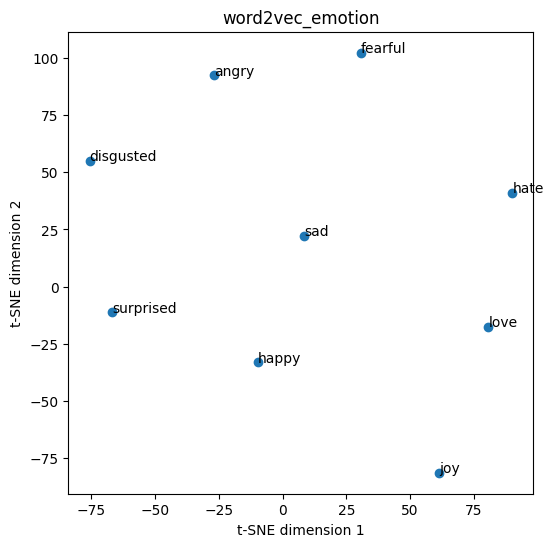

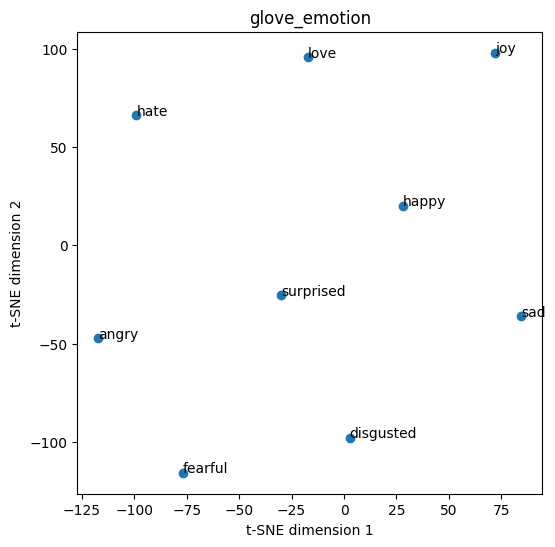

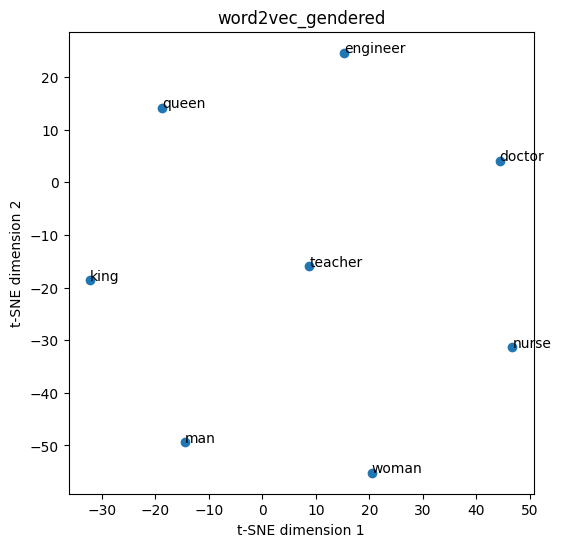

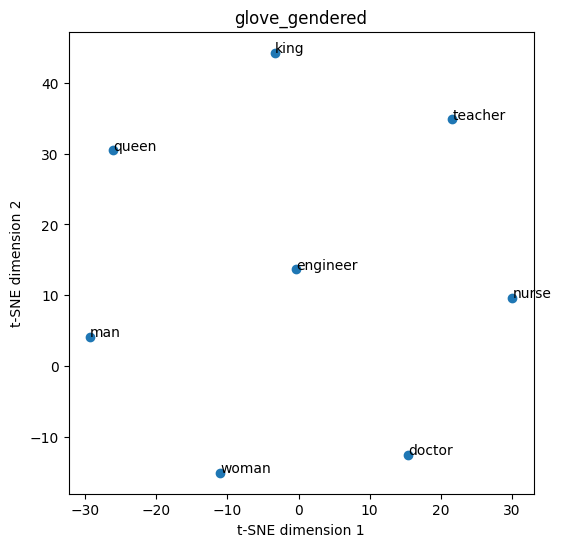

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.2

In [43]:
def main():
    # read in data from the json files
    unformatted_training_data = convert_json_to_object(training_data_file_path, training_one_num_objs)
    unformatted_testing_data = convert_json_to_object(testing_data_file_path, training_one_num_objs)

    # ---------------------------------------------------------
    #                   Test 1
    # ---------------------------------------------------------
    training_data = preprocess_data(unformatted_training_data) # 80,000 reviews
    testing_data = preprocess_data(unformatted_testing_data)
    nb_classifier = nltk.NaiveBayesClassifier.train(training_data)
    print('---------------------------------------------------------')
    print('                         Test 1')
    print('---------------------------------------------------------')
    print('------------ The Naive Bayes Classifier! ------------')
    nb_metrics = model_analysis(nb_classifier, testing_data)
    sklearn_classifier = LogisticRegression(max_iter=1000)
    lr_classifier = SklearnClassifier(sklearn_classifier)
    lr_classifier.train(training_data)
    print('------------ The Logistic Regression Classifier! ------------')
    lr_metrics = model_analysis(lr_classifier, testing_data)
    # model_evaluation(nb_metrics, lr_metrics, training_one_num_objs)

    # ---------------------------------------------------------
    #                   Test 2
    # ---------------------------------------------------------
    training_data = preprocess_data(unformatted_training_data.iloc[30000:50000]) # 20,000 DATA SETS
    testing_data = preprocess_data(unformatted_testing_data)
    nb_classifier = nltk.NaiveBayesClassifier.train(training_data)
    print('---------------------------------------------------------')
    print('                         Test 2')
    print('---------------------------------------------------------')
    print('------------ The Naive Bayes Classifier! ------------')
    nb_metrics = model_analysis(nb_classifier, testing_data)
    sklearn_classifier = LogisticRegression()
    lr_classifier = SklearnClassifier(sklearn_classifier)
    lr_classifier.train(training_data)
    print('------------ The Logistic Regression Classifier! ------------')
    lr_metrics = model_analysis(lr_classifier, testing_data)
    # model_evaluation(nb_metrics, lr_metrics, training_two_num_objs)

    # ---------------------------------------------------------
    #                   Test 3
    # ---------------------------------------------------------
    training_data = preprocess_data(unformatted_training_data.iloc[35000:45000]) # 10,000 DATA SETS
    testing_data = preprocess_data(unformatted_testing_data)
    nb_classifier = nltk.NaiveBayesClassifier.train(training_data)
    print('---------------------------------------------------------')
    print('                         Test 3')
    print('---------------------------------------------------------')
    print('------------ The Naive Bayes Classifier! ------------')
    nb_metrics = model_analysis(nb_classifier, testing_data)
    sklearn_classifier = LogisticRegression()
    lr_classifier = SklearnClassifier(sklearn_classifier)
    lr_classifier.train(training_data)
    print('------------ The Logistic Regression Classifier! ------------')
    lr_metrics = model_analysis(lr_classifier, testing_data)
    # model_evaluation(nb_metrics, lr_metrics, training_two_num_objs)

    # ---------------------------------------------------------
    #                   Test 4
    # ---------------------------------------------------------
    training_data = preprocess_data(unformatted_training_data.iloc[37500:47500]) # 5,000 DATA SETS
    testing_data = preprocess_data(unformatted_testing_data)
    nb_classifier = nltk.NaiveBayesClassifier.train(training_data)
    print()
    print('---------------------------------------------------------')
    print('                         Test 4')
    print('---------------------------------------------------------')
    print('------------ The Naive Bayes Classifier! ------------')
    nb_metrics = model_analysis(nb_classifier, testing_data)
    sklearn_classifier = LogisticRegression()
    lr_classifier = SklearnClassifier(sklearn_classifier)
    lr_classifier.train(training_data)
    print('------------ The Logistic Regression Classifier! ------------')
    lr_metrics = model_analysis(lr_classifier, testing_data)
    # model_evaluation(nb_metrics, lr_metrics, training_two_num_objs)


    analyze_pretrained_vectors()

    create_submission_document()

if __name__ == "__main__":
    main()

In [33]:
def create_submission_document():
    !sudo apt-get update
    !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-recommended
    !pip install nbconvert
    !jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/KobeNorcross-NLP-HW2.ipynb" --to pdf

# Discussion
### Pretrained vectors
For the emotion words of the two pretrained embeddings, there is a difference in placement of the embeddings. The first thing I note about these tsne graphs is the word most in center of the graph. The reason I take note of it is to see what word is the most similar to the list of words given.The first graph displayed is the word2vec emotion graph, and at the center of this plot, the word 'sad' appears. It is very clsoe to happy which makes the most sense, and surrounding it is all the other words. Now on the glove emotion graph, 'surprised' appears. This is kind of surprising because I would not have chosen surprised to appear within the center. Upon, inspecting the other words, I actually believe that this is a good fit for being in the center since most words can be somewhat related to the emotion of surprised. Whereas, with 'sad' in the middle, it is not as universal to relate words to it unless it comes to synonyimty and antonymity. I was going to chose one over the other, but between the two graphs, I can't really pick which one is better than the other. I think I like word2vec just a slight bit more than the glove for this list of emotion words since the placement of the word 'disgusted' is not around all the emotions that I think are similar to it appear, while word2vec has a more desirable placement of the word 'disgusted.'
Now for the gendered words, 'teacher' appears in the middle of the graph. This implies that this occupation is neutral. In this model, the positions of power, king and queen, alongside engineering, appear to be in favor of man. While the more medicinal fields seem to be more for women. This may be a bit of bias placed on the word2vec model since this data was from google news. For glove, 'engineer' appears within the middle of the graph, which implies that it found that it is pretty neutral for both genders. The only difference between the two graphs seem to be that 'engineer' has switched places with 'teacher' and 'king' and 'queen' have switched places. Overall, I think that the glove model is not as good as queen is placed very closely to man whereas in the word2vec model, king and queen are switched. I don't really know how to analyze which is better as both don't really make sense with their placing since I would honestly think that gender would be in relation to all of the gendered words.



### Results and Analysis
This time around I added more tests than assignment 1 to see teh changes in test sizes. Test 1 featured the full suite of training data (80,000) reviews wheras in test 2, I only trained the classifiers on 20,000 reviews. This had little difference in results and shows that 20,000 reviews may be more worth it than training the full 80,000. The f1 measurement is decreased by about 0.01 and 0.02 for the corresponding classifier respectively. I don't think training an additional 60,000 reviews is very helpful for the small improvement because of memory and speed for this script.
Now from test 2 to test 3 there there is about the same amount of change in f1 measurements for their corresponding classifiers, the difference in test data is from 20,000 in test 2, and 10,000 reviews in test 3. So again, the amount of reviews got cut in half and only loses a minimal amount of score. Not enough to worry about.
Lastly, the changes from test 3 to test 4 may not be worth it. Test 3 was trained on 5,000 reviews which is half of test 3, but the precision of the Naive Bayes classifier drops down to 0.73 where it was 0.83 in test 3. I think that if I were to find a sweeet spot, it would be an amount of reviews that is close to test 3 as there weren't significant changes between the full training set and 10,000 reviews. From 80,000 to 10,000 with little change is fantastic!